<a href="https://colab.research.google.com/github/blkeyd/CVPR/blob/main/Final/Paper/E_AlexNet%2BGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enhanced ALexNet + GAN

Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Paths

In [4]:
real_fire_dir = "/content/drive/MyDrive/fire_dataset_split/train/fire"
gan_fire_dir  = "/content/drive/MyDrive/gan_generated_fire"
nofire_dir    = "/content/drive/MyDrive/fire_dataset_split/train/nofire"
val_dir       = "/content/drive/MyDrive/fire_dataset_split/val"
test_dir      = "/content/drive/MyDrive/fire_dataset_split/test"

Transforms

In [5]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

Custom Dataset for GAN images

In [6]:
class GANFireDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.images = [os.path.join(folder_path,f)
                       for f in os.listdir(folder_path) if f.endswith(".png")]
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = 0  # fire class
        return img, label

Load Datasets

In [7]:
# Real fire images
real_fire_dataset = datasets.ImageFolder(os.path.dirname(real_fire_dir), transform=transform)
fire_class_index = real_fire_dataset.class_to_idx['fire']
real_fire_dataset.samples = [s for s in real_fire_dataset.samples if s[1]==fire_class_index]

# GAN fire images
gan_fire_dataset = GANFireDataset(gan_fire_dir, transform=transform)

# No-fire images
nofire_dataset = datasets.ImageFolder(os.path.dirname(nofire_dir), transform=transform)
nofire_class_index = nofire_dataset.class_to_idx['nofire']
nofire_dataset.samples = [s for s in nofire_dataset.samples if s[1]==nofire_class_index]

# Merge datasets
train_dataset = ConcatDataset([real_fire_dataset, gan_fire_dataset, nofire_dataset])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Validation & Test datasets
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

SE Block

In [8]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = nn.functional.adaptive_avg_pool2d(x,1).view(b,c)
        y = nn.functional.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b,c,1,1)
        return x * y

Enhanced AlexNet

In [9]:
class EnhancedAlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1),

            SEBlock(384),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*6*6, 4096),
            nn.LeakyReLU(0.1),

            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(0.1),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Initialize Model

In [10]:
model = EnhancedAlexNet(num_classes=2).to(device)

Loss and Optimizer

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Training Function

In [12]:
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
        train_acc = 100*correct/total

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()
        val_acc = 100*val_correct/val_total

        print(f"Epoch [{epoch+1}/{epochs}] Train Acc: {train_acc:.2f}%  Val Acc: {val_acc:.2f}%")

Evaluation function

In [13]:
def evaluate_model(model, test_loader):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs,1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=['fire','nofire']))

Train and Evaluate

In [14]:
train_model(model, train_loader, val_loader, epochs=10)
evaluate_model(model, test_loader)

Epoch [1/10] Train Acc: 92.31%  Val Acc: 88.00%
Epoch [2/10] Train Acc: 96.56%  Val Acc: 95.20%
Epoch [3/10] Train Acc: 98.32%  Val Acc: 97.20%
Epoch [4/10] Train Acc: 97.88%  Val Acc: 95.20%
Epoch [5/10] Train Acc: 97.73%  Val Acc: 96.80%
Epoch [6/10] Train Acc: 97.80%  Val Acc: 96.40%
Epoch [7/10] Train Acc: 98.39%  Val Acc: 97.60%
Epoch [8/10] Train Acc: 98.02%  Val Acc: 97.60%
Epoch [9/10] Train Acc: 98.98%  Val Acc: 97.20%
Epoch [10/10] Train Acc: 98.76%  Val Acc: 98.40%
Confusion Matrix:
 [[198   2]
 [  4  34]]

Classification Report:
               precision    recall  f1-score   support

        fire       0.98      0.99      0.99       200
      nofire       0.94      0.89      0.92        38

    accuracy                           0.97       238
   macro avg       0.96      0.94      0.95       238
weighted avg       0.97      0.97      0.97       238



Confusion Matrix

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix – AlexNet Classification")
    plt.tight_layout()
    plt.show()

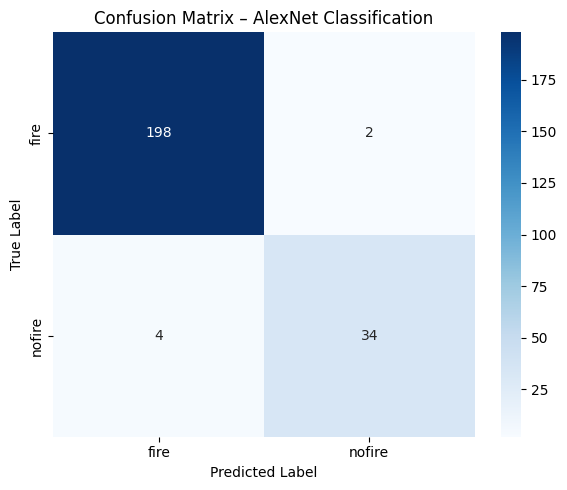

In [16]:
class_names = test_loader.dataset.classes
plot_confusion_matrix(model, test_loader, class_names)

ROC Curve

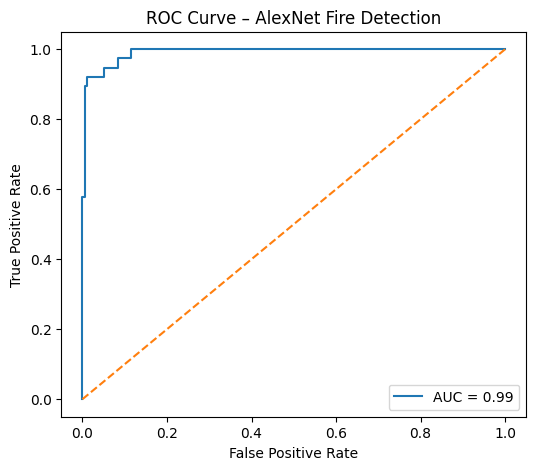

In [17]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, test_loader):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs[:, 1].cpu().numpy())  # probability of "fire"
            all_labels.extend(labels.cpu().numpy())

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve – AlexNet Fire Detection")
    plt.legend()
    plt.show()

plot_roc_curve(model, test_loader)

Save Model

In [18]:
torch.save(model.state_dict(), "/content/drive/MyDrive/enhanced_alexnet_gan_fire.pth")
print("Enhanced AlexNet + GAN model saved.")

Enhanced AlexNet + GAN model saved.
